[Alibi Detect Project GitHub](https://github.com/SeldonIO/alibi-detect)

In [1]:
import sys, os, random, shutil, warnings, glob

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras

from keras import layers
from keras import Sequential

import cv2

sns.set_style('darkgrid')

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def seed_all(value=42):
    random.seed(value)
    np.random.seed(value)
    tf.random.set_seed(value)
    os.environ['PYTHONHASHSEED'] = str(value)
#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
seed_all()

In [3]:
IMAGE_ROOT  = "/kaggle/input/mvtec-ad/hazelnut"

IMAGE_SIZE = (64, 64)

# Dataset ...

In [4]:
def get_subset(pathname, name=""):
    images = list()

    for fn in tqdm(glob.glob(pathname), desc=name):
        image = cv2.imread(fn, flags=cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE).astype(np.float32) / 255.0
        images.append(image)

    return np.array(images)

In [5]:
x_train = get_subset(os.path.join(IMAGE_ROOT, 'train', 'good', '*.png'), 'Train images')

Train images: 100%|██████████| 391/391 [00:21<00:00, 18.25it/s]


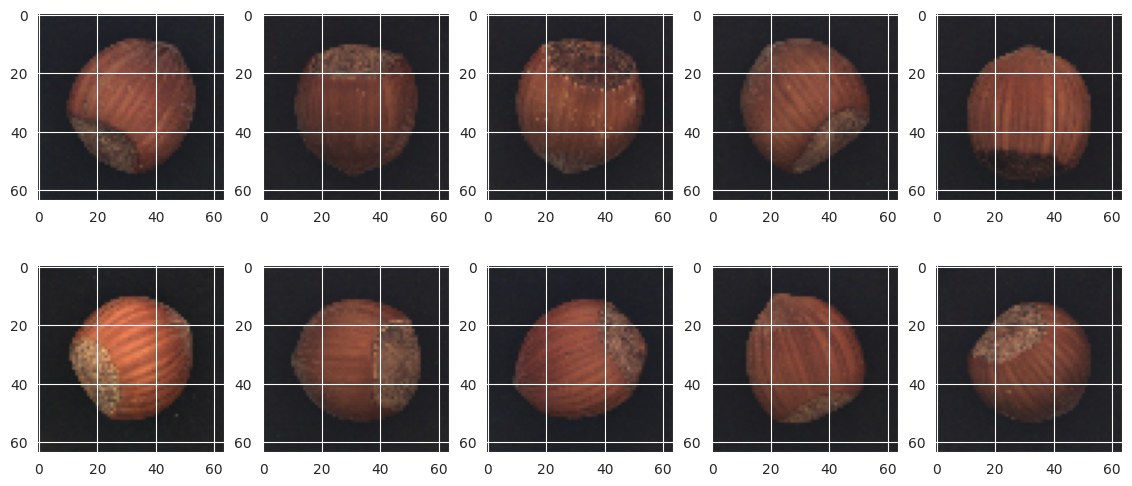

In [6]:
rows, cols = 2, 5
fig=plt.figure(figsize=(14, 6))
for i in range(1, rows*cols+1):
    fig.add_subplot(rows, cols, i)
    image = x_train[random.randrange(x_train.shape[0])]
    plt.imshow(image)
plt.show()

# AutoEncoder Model

In [7]:
# LATENT_DIM = 10240
# DENSE_DIM = (4, 4, 512)

def create_model(X_shape, classes=3, name="Model"):
    
    def conv_block(x, filters, *, kernels=None, steps=None, dim_transform=None, name=""):
        for i in range(len(filters)):
            x = layers.Conv2D(filters[i], kernels[i] if kernels else (3, 3), strides=steps[i] if steps else (1, 1), padding='same', name=f'{name}_conv_{i}')(x)
            x = layers.BatchNormalization(name=f'{name}_norm_{i}')(x)
            x = layers.Activation('relu', name=f'{name}_relu_{i}')(x)
        if dim_transform == 'maxpool':
            x = layers.MaxPooling2D((2, 2), name=f'{name}_maxpool')(x)
        elif dim_transform == "upsampl":
            x = layers.UpSampling2D((2, 2), name=f'{name}_upsampl')(x)
        return x
    
    inputs = x = keras.Input(X_shape[-3:], name='inputs')
    
    x = conv_block(x, (64,  ), dim_transform='maxpool', name="enc_1")
    x = conv_block(x, (128, ), dim_transform='maxpool', name="enc_2")
    x = conv_block(x, (256, ), dim_transform='maxpool', name="enc_3")
    x = conv_block(x, (512, ), dim_transform='maxpool', name="enc_4")

#     x = layers.Flatten(name="flatten")(x)
#     x = layers.Dense(LATENT_DIM, name="latent")(x)
    
#     x = layers.Dense(np.prod(DENSE_DIM), name="dec_dense")(x)
#     x = layers.Reshape(target_shape=DENSE_DIM, name="dec_reshape")(x)

    x = conv_block(x, (512, ), dim_transform='upsampl', name="dec_4")
    x = conv_block(x, (256, ), dim_transform='upsampl', name="dec_3")
    x = conv_block(x, (128, ), dim_transform='upsampl', name="dec_2")
    x = conv_block(x, (64,  ), dim_transform='upsampl', name="dec_1")

    outputs = layers.Conv2D(classes, (1, 1), activation="sigmoid", padding='same', name='ouputs')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name=name)

In [8]:
model = create_model(x_train.shape, 3)

model.compile(optimizer="adam", loss='mean_squared_error', metrics=['accuracy'])
model.summary(line_length=110)

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)                            │ (None, 64, 64, 3)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_1_conv_0 (Conv2D)                          │ (None, 64, 64, 64)                  │               1,792 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_1_norm_0 (BatchNormalization)              │ (None, 64, 64, 64)                  │                 256 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_1_relu_0 (Activation)                      │ (None, 64, 64, 64)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_1_maxpool (MaxPooling2D)                   │ (None, 32, 32, 64)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_2_conv_0 (Conv2D)                          │ (None, 32, 32, 128)                 │              73,856 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_2_norm_0 (BatchNormalization)              │ (None, 32, 32, 128)                 │                 512 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_2_relu_0 (Activation)                      │ (None, 32, 32, 128)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_2_maxpool (MaxPooling2D)                   │ (None, 16, 16, 128)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_3_conv_0 (Conv2D)                          │ (None, 16, 16, 256)                 │             295,168 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_3_norm_0 (BatchNormalization)              │ (None, 16, 16, 256)                 │               1,024 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_3_relu_0 (Activation)                      │ (None, 16, 16, 256)                 │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_3_maxpool (MaxPooling2D)                   │ (None, 8, 8, 256)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_4_conv_0 (Conv2D)                          │ (None, 8, 8, 512)                   │           1,180,160 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_4_norm_0 (BatchNormalization)              │ (None, 8, 8, 512)                   │               2,048 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_4_relu_0 (Activation)                      │ (None, 8, 8, 512)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ enc_4_maxpool (MaxPooling2D)                   │ (None, 4, 4, 512)                   │                   0 │
├───

 Total params: 5,467,395 (20.86 MB)

 Trainable params: 5,463,555 (20.84 MB)

 Non-trainable params: 3,840 (15.00 KB)

# FIT MODEL ...

In [9]:
MODEL_CHECKPOINT = f"/kaggle/working/model/{model.name}.keras"
EPOCHS = 100

callbacks_list = [
#     keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20),
    keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
]

history = model.fit(
    x=x_train,
    y=x_train,
    epochs=EPOCHS, 
    callbacks=callbacks_list, 
    validation_split=0.2,
    verbose=1)

model.load_weights(MODEL_CHECKPOINT)

Epoch 1/100
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5546 - loss: 0.0919

I0000 00:00:1725613543.876985      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.5542 - loss: 0.0825
Epoch 1: val_accuracy improved from -inf to 0.57897, saving model to /kaggle/working/model/Model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5546 - loss: 0.0802 - val_accuracy: 0.5790 - val_loss: 0.1147
Epoch 2/100
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6326 - loss: 0.0174
Epoch 2: val_accuracy improved from 0.57897 to 0.58526, saving model to /kaggle/working/model/Model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6412 - loss: 0.0166 - val_accuracy: 0.5853 - val_loss: 0.1514
Epoch 3/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8066 - loss: 0.0079
Epoch 3: val_accuracy improved from 0.58526 to 0.58529, saving model to /kaggle/working/model/Model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8063 - loss: 0.0078 - val_accuracy: 0.5853 - val_loss: 0.1130
Epoch 4/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8139 - loss: 0.0047
Epoch

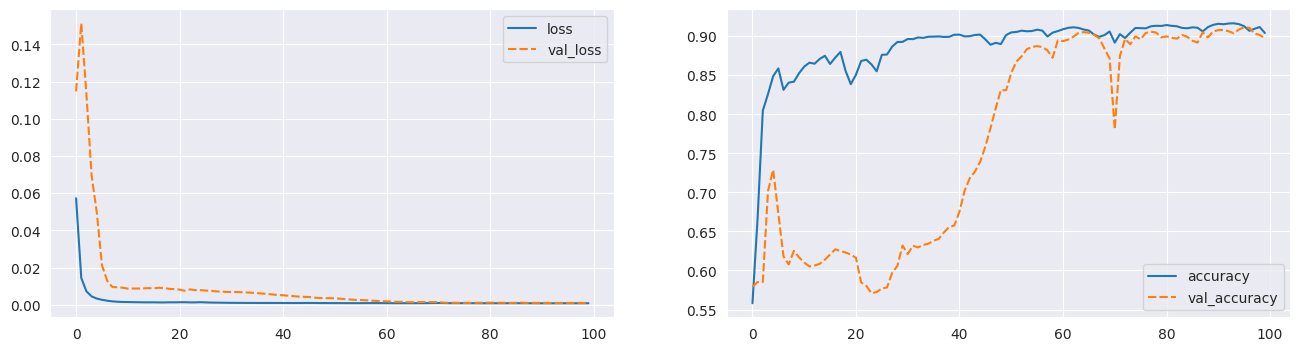

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.lineplot(data={k: history.history[k] for k in ('loss', 'val_loss')}, ax=ax[0])
sns.lineplot(data={k: history.history[k] for k in history.history.keys() if k not in ('loss', 'val_loss')}, ax=ax[1])
plt.show()

# Evaluate model ...

good nuts: 100%|██████████| 40/40 [00:02<00:00, 19.79it/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


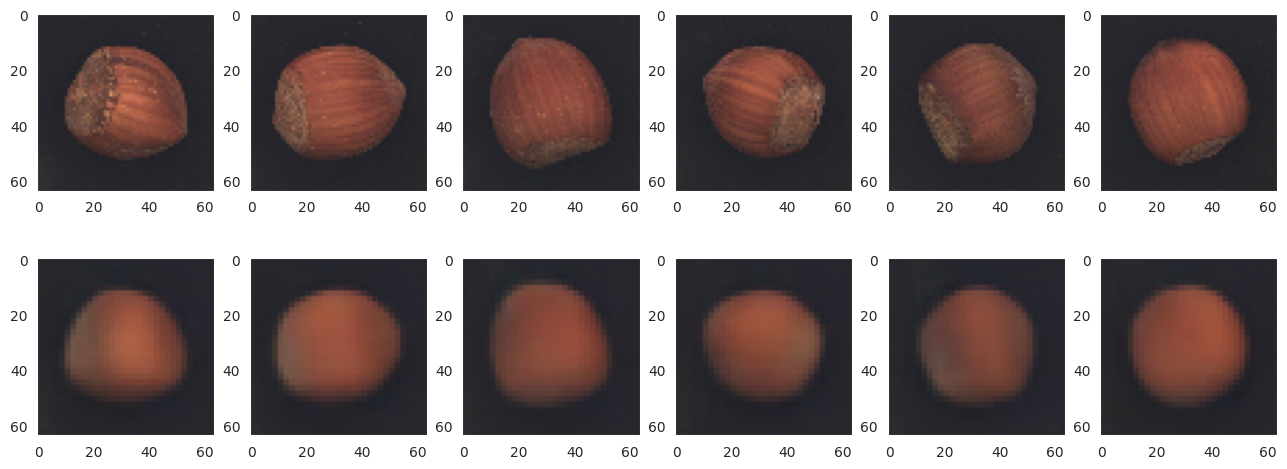

In [11]:
LABEL = 'good'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

x_pred = model.predict(x_test)

rows, cols = 3, 6
fig=plt.figure(figsize=(16, 9))

for i, ind in enumerate(random.sample(range(x_pred.shape[0]), cols)):
    fig.add_subplot(rows, cols, i + 1)
    image = x_test[ind]
    plt.grid(False)
    plt.imshow(image)
    
    fig.add_subplot(rows, cols, i + cols + 1)
    image = x_pred[ind]
    plt.grid(False)
    plt.imshow(image)    

plt.show()

crack nuts: 100%|██████████| 18/18 [00:00<00:00, 19.88it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


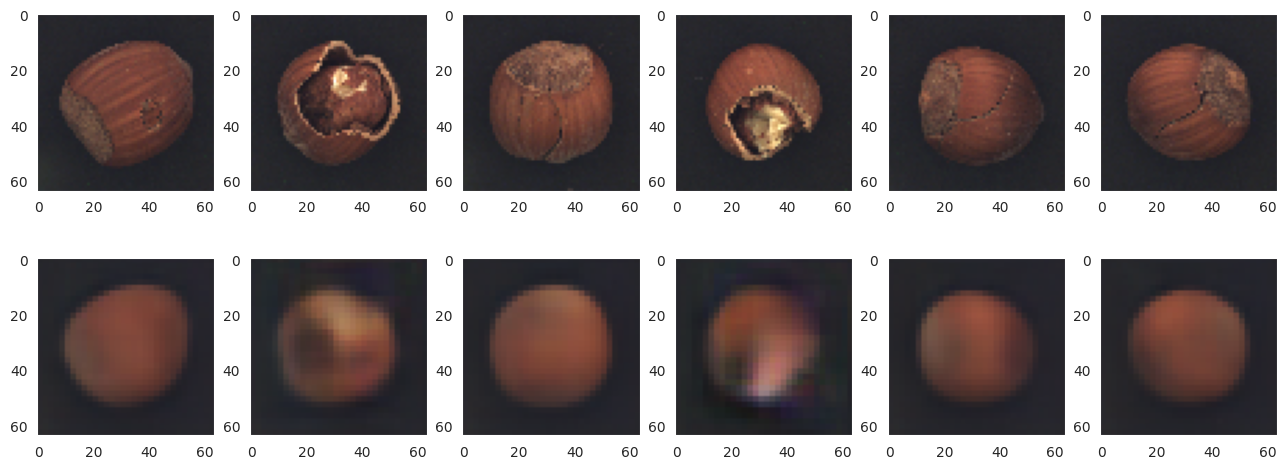

In [12]:
LABEL = 'crack'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

x_pred = model.predict(x_test)

rows, cols = 3, 6
fig=plt.figure(figsize=(16, 9))

for i, ind in enumerate(random.sample(range(x_pred.shape[0]), cols)):
    fig.add_subplot(rows, cols, i + 1)
    image = x_test[ind]
    plt.grid(False)    
    plt.imshow(image)
    
    fig.add_subplot(rows, cols, i + cols + 1)
    image = x_pred[ind]
    plt.grid(False)
    plt.imshow(image)    

plt.show()

cut nuts: 100%|██████████| 17/17 [00:00<00:00, 19.01it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


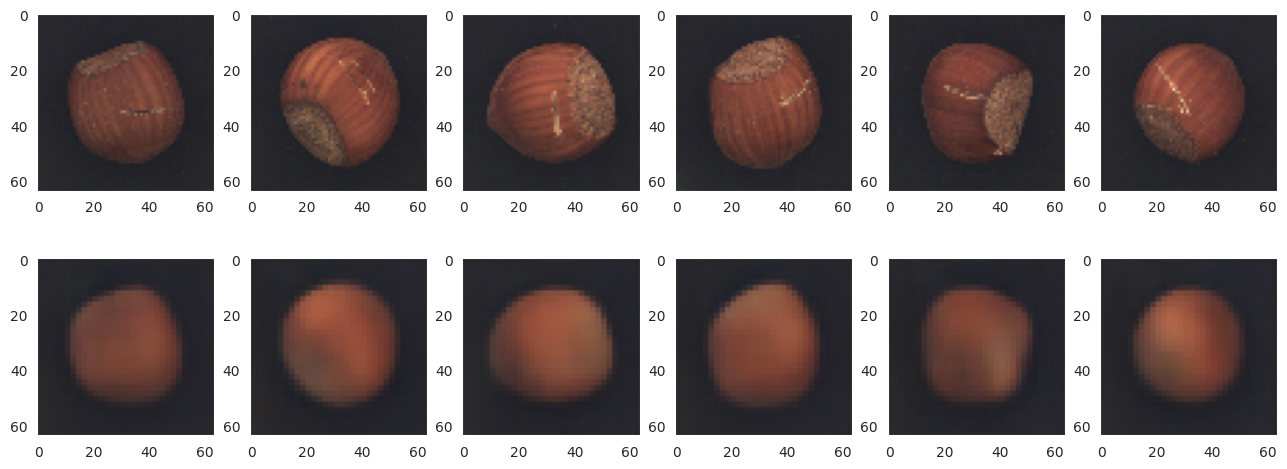

In [13]:
LABEL = 'cut'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

x_pred = model.predict(x_test)

rows, cols = 3, 6
fig=plt.figure(figsize=(16, 9))

for i, ind in enumerate(random.sample(range(x_pred.shape[0]), cols)):
    fig.add_subplot(rows, cols, i + 1)
    image = x_test[ind]
    plt.grid(False)
    plt.imshow(image)
    
    fig.add_subplot(rows, cols, i + cols + 1)
    image = x_pred[ind]
    plt.grid(False)
    plt.imshow(image)    

plt.show()

hole nuts: 100%|██████████| 18/18 [00:00<00:00, 20.03it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


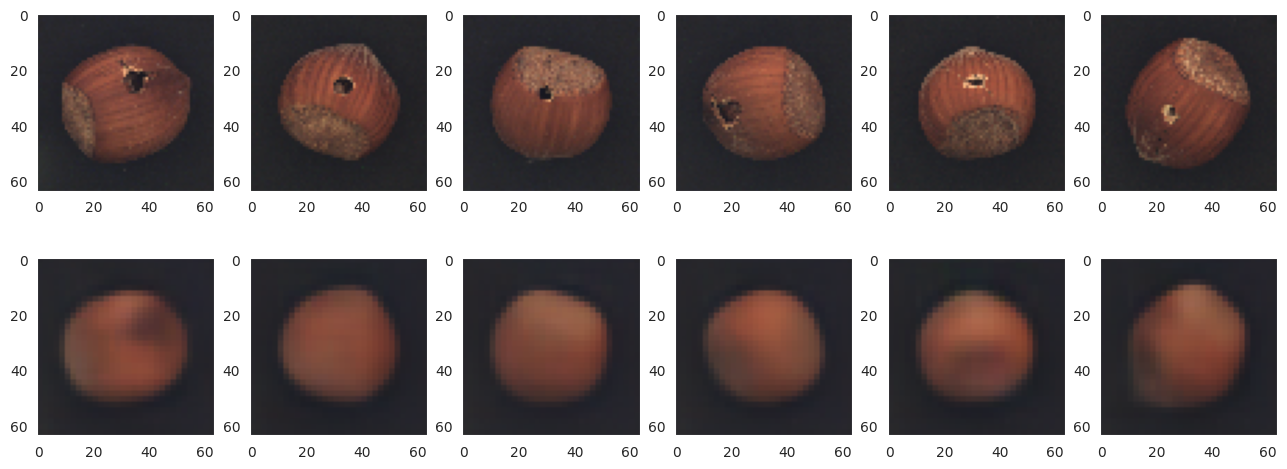

In [14]:
LABEL = 'hole'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

x_pred = model.predict(x_test)

rows, cols = 3, 6
fig=plt.figure(figsize=(16, 9))

for i, ind in enumerate(random.sample(range(x_pred.shape[0]), cols)):
    fig.add_subplot(rows, cols, i + 1)
    image = x_test[ind]
    plt.grid(False)
    plt.imshow(image)
    
    fig.add_subplot(rows, cols, i + cols + 1)
    image = x_pred[ind]
    plt.grid(False)
    plt.imshow(image)    

plt.show()

#  Anomaly Detection ...

In [15]:
!pip install alibi-detect

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.5/381.5 kB 7.8 MB/s eta 0:00:00


In [16]:
from alibi_detect.od import OutlierAE

THRESHOLD = 0.005

od = OutlierAE(threshold=THRESHOLD, ae=model, data_type='image')

In [17]:
LABEL = 'good'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

pred = od.predict(x_test, 
                  outlier_type='instance',
                  outlier_perc=20,
                  return_feature_score=True,
                  return_instance_score=True)


outliers = pred['data']['is_outlier']
print(f"Correctly predicted: {(outliers == 0).sum() / len(outliers):.00%}")

good nuts: 100%|██████████| 40/40 [00:01<00:00, 26.12it/s]


Correctly predicted: 95%


crack nuts: 100%|██████████| 18/18 [00:00<00:00, 25.43it/s]


Correctly predicted: 67%


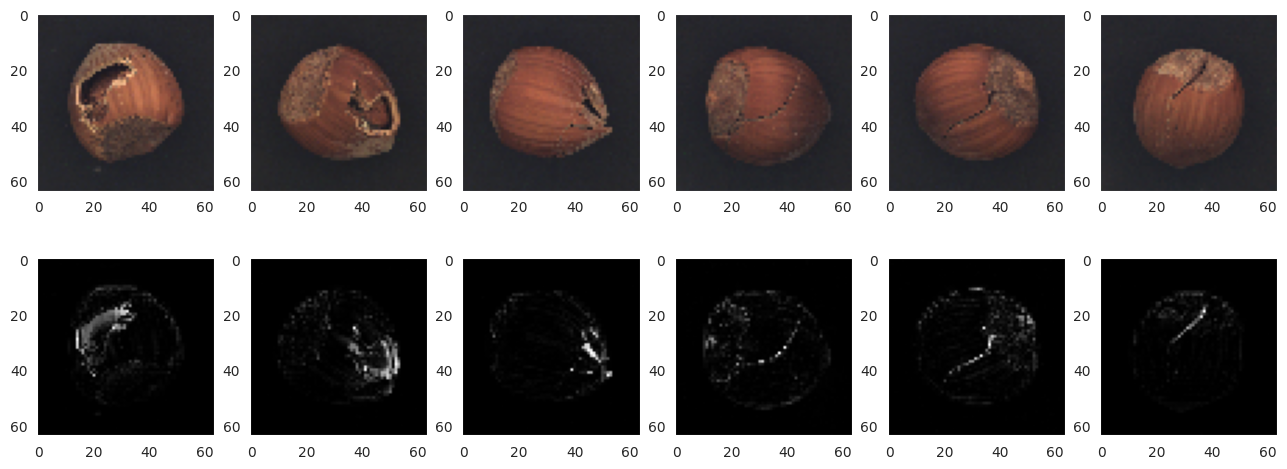

In [18]:
LABEL = 'crack'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

pred = od.predict(x_test, 
                  outlier_type='instance',
                  outlier_perc=20,
                  return_feature_score=True,
                  return_instance_score=True)


outliers = pred['data']['is_outlier']
print(f"Correctly predicted: {(outliers == 1).sum() / len(outliers):.00%}")

x_pred = pred['data']['feature_score']
x_pred = np.linalg.norm(x_pred, axis=-1, keepdims=True)

rows, cols = 3, 6
fig=plt.figure(figsize=(16, 9))

for i, ind in enumerate(random.sample(range(x_pred.shape[0]), cols)):
    fig.add_subplot(rows, cols, i + 1)
    image = x_test[ind]
    plt.grid(False)    
    plt.imshow(image)
    
    fig.add_subplot(rows, cols, i + cols + 1)
    image = x_pred[ind]
    plt.grid(False)
    plt.imshow(image, cmap='gray')

plt.show()

cut nuts: 100%|██████████| 17/17 [00:00<00:00, 25.68it/s]


Correctly predicted: 29%


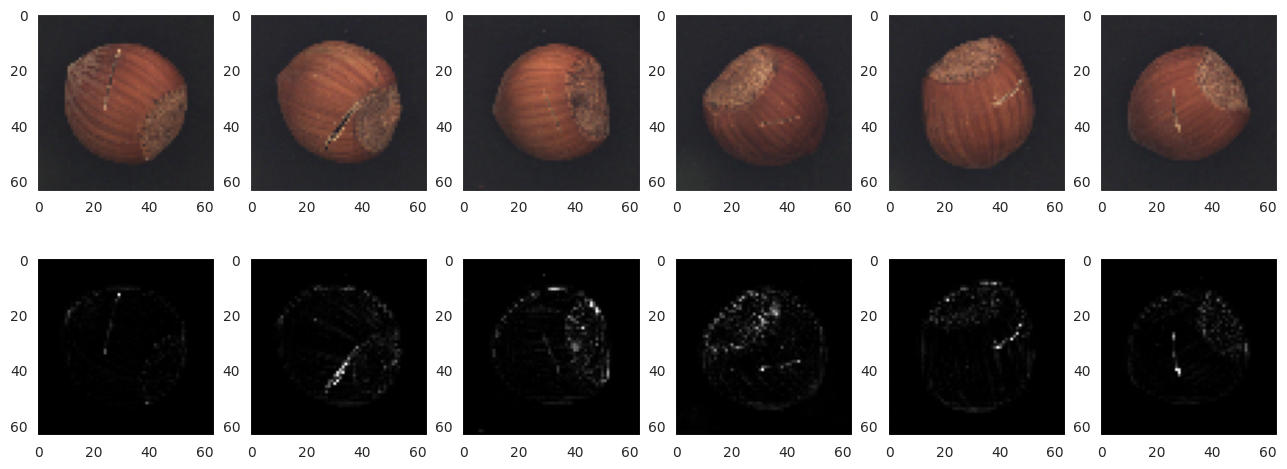

In [19]:
LABEL = 'cut'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

pred = od.predict(x_test, 
                  outlier_type='instance',
                  outlier_perc=20,
                  return_feature_score=True,
                  return_instance_score=True)


outliers = pred['data']['is_outlier']
print(f"Correctly predicted: {(outliers == 1).sum() / len(outliers):.00%}")

x_pred = pred['data']['feature_score']
x_pred = np.linalg.norm(x_pred, axis=-1, keepdims=True)

rows, cols = 3, 6
fig=plt.figure(figsize=(16, 9))

for i, ind in enumerate(random.sample(range(x_pred.shape[0]), cols)):
    fig.add_subplot(rows, cols, i + 1)
    image = x_test[ind]
    plt.grid(False)    
    plt.imshow(image)
    
    fig.add_subplot(rows, cols, i + cols + 1)
    image = x_pred[ind]
    plt.grid(False)
    plt.imshow(image, cmap='gray')

plt.show()

hole nuts: 100%|██████████| 18/18 [00:00<00:00, 25.59it/s]


Correctly predicted: 72%


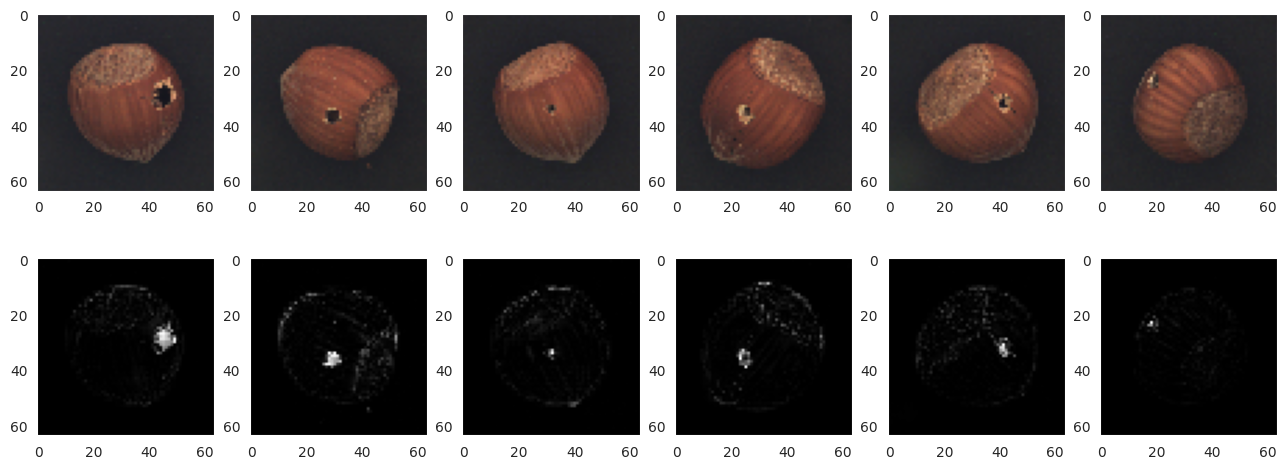

In [20]:
LABEL = 'hole'

x_test = get_subset(os.path.join(IMAGE_ROOT, 'test', LABEL, '*.png'), f"{LABEL} nuts")

pred = od.predict(x_test, 
                  outlier_type='instance',
                  outlier_perc=20,
                  return_feature_score=True,
                  return_instance_score=True)


outliers = pred['data']['is_outlier']
print(f"Correctly predicted: {(outliers == 1).sum() / len(outliers):.00%}")

x_pred = pred['data']['feature_score']
x_pred = np.linalg.norm(x_pred, axis=-1, keepdims=True)

rows, cols = 3, 6
fig=plt.figure(figsize=(16, 9))

for i, ind in enumerate(random.sample(range(x_pred.shape[0]), cols)):
    fig.add_subplot(rows, cols, i + 1)
    image = x_test[ind]
    plt.grid(False)    
    plt.imshow(image)
    
    fig.add_subplot(rows, cols, i + cols + 1)
    image = x_pred[ind]
    plt.grid(False)
    plt.imshow(image, cmap='gray')

plt.show()